In [ ]:
# Lectura de dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

file_path = r"D:\01_Información\05_Ingeniería civil\01_Proyectos\...\01_Resultados de ensayos\Investigaciones_07-05-2025.xlsm"
df_t = pd.read_excel(file_path, sheet_name="WGPT")
df_g = pd.read_excel(file_path, sheet_name="WGPG")
df_d = pd.read_excel(file_path, sheet_name="09_DIQU")
df_l = pd.read_excel(file_path, sheet_name="LOCA")

c:\Program Files\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Program Files\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
x_id = 'xxx'
excluir_ids = []
df_x2 = df_g[df_g['LOCA_NAME']==x_id].reset_index(drop=True)

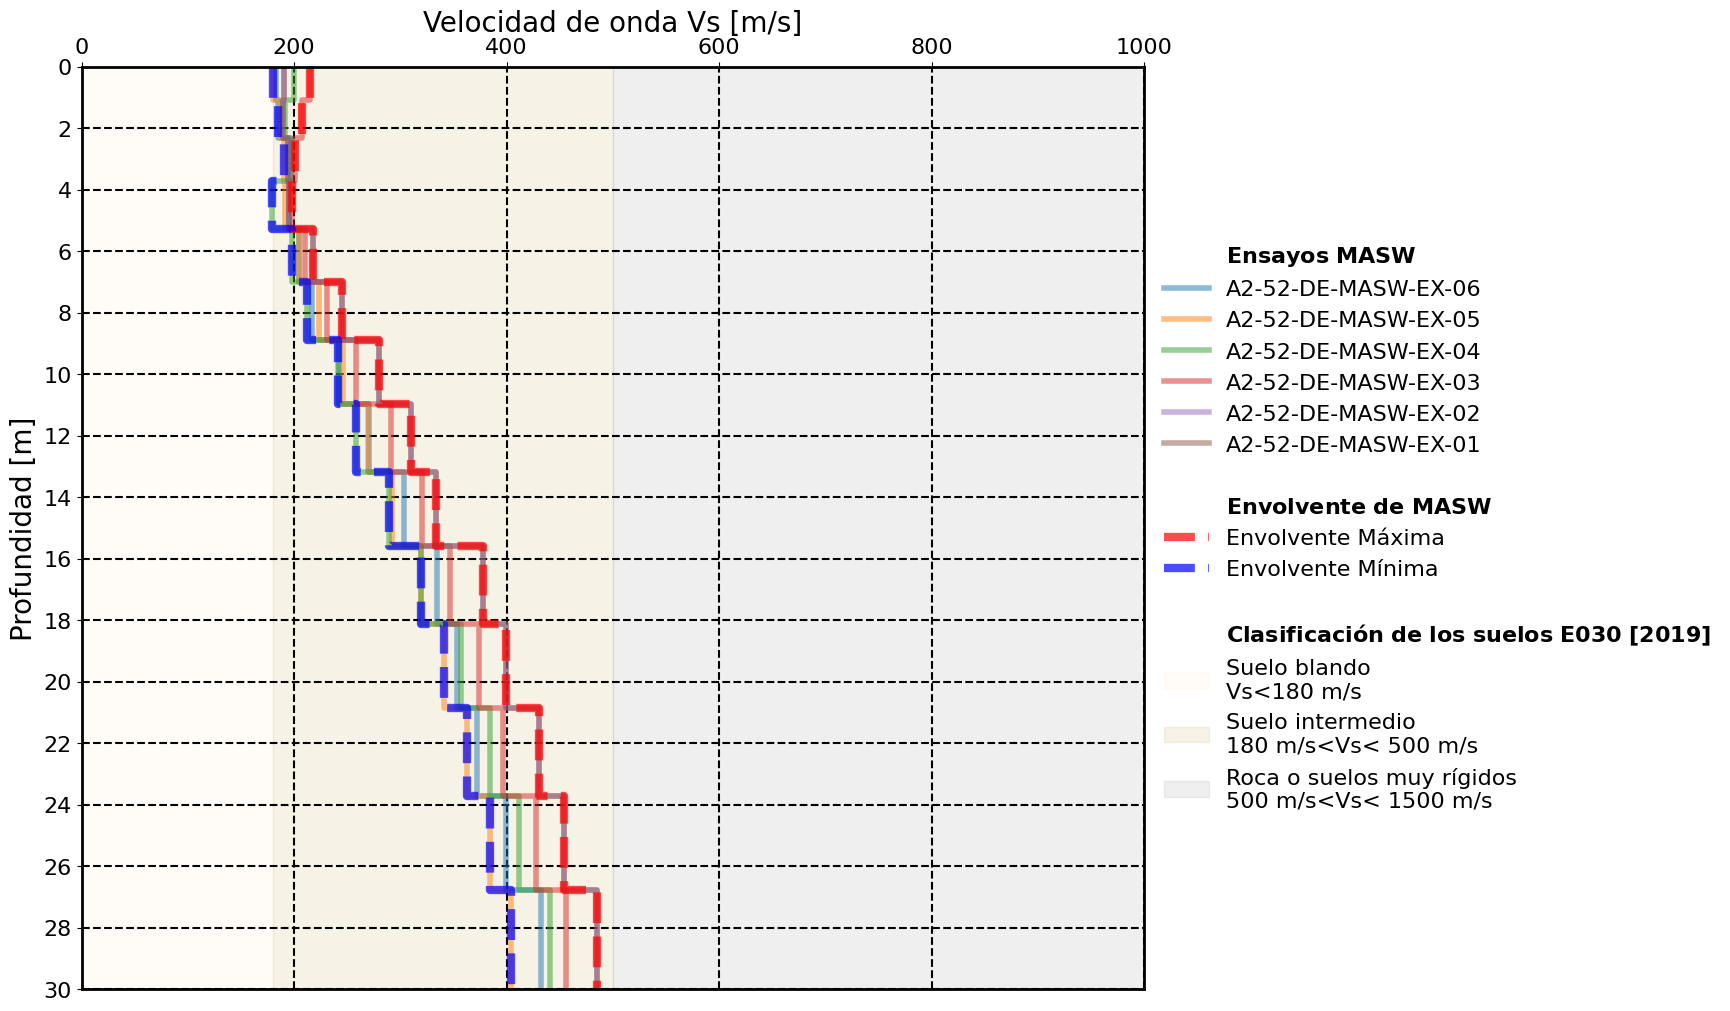

In [351]:
fig = plt.figure(figsize=(20, 10),constrained_layout=True)
gs = fig.add_gridspec(1,5, wspace=0.1)

#-----------------------------------------------------------
#Grafica de MASW
ax2 = fig.add_subplot(gs[0,0:4])

# Lista para acumular todos los puntos
all_points = []

for j in range(len(df_x2)):
    m_id = df_x2['LOCA_ID'][j]
    df_x3 =  df_t[df_t['LOCA_ID']==m_id]
    df_x3 =  df_x3[df_x3['WGPG_PARA']=='VS'].reset_index(drop=True)
    all_points.append(df_x3)
        
    # Construcción del nuevo DataFrame
    new_rows = [(0.0, df_x3.loc[0, "WGPG_RDNG"])]  # Primer punto (0.0, primer valor de lectura)
    for k in range(len(df_x3)):
        new_rows.append((df_x3.loc[k, "WGPG_DPTH"], df_x3.loc[k, "WGPG_RDNG"]))
        if k < len(df_x3) - 1:
            new_rows.append((df_x3.loc[k, "WGPG_DPTH"], df_x3.loc[k + 1, "WGPG_RDNG"]))

    # Creación del nuevo DataFrame
    df_x3 = pd.DataFrame(new_rows, columns=["WGPG_DPTH", "WGPG_RDNG"])
    
    x = df_x3["WGPG_RDNG"]
    y = df_x3["WGPG_DPTH"]  
                    
    ax2.plot(x, y, linestyle='-', linewidth=4, alpha=0.5, label=m_id)


# Crear DataFrame
df_all = pd.concat([
    df for df in all_points if df["LOCA_ID"].iloc[0] not in excluir_ids
])

# Agrupar por profundidad y calcular envolvente superior e inferior
df_env = df_all.groupby("WGPG_DPTH").agg(
    max_RDNG = ("WGPG_RDNG", "max"),
    min_RDNG = ("WGPG_RDNG", "min"),
    avg_RDNG = ("WGPG_RDNG", "mean")   # 👈 Aquí calculas el promedio real
).reset_index()

# Construir envolvente escalonada de la máxima
max_rows = [(0.0, df_env.loc[0, "max_RDNG"])]
for k in range(len(df_env)):
    max_rows.append((df_env.loc[k, "WGPG_DPTH"], df_env.loc[k, "max_RDNG"]))
    if k < len(df_env) - 1:
        max_rows.append((df_env.loc[k, "WGPG_DPTH"], df_env.loc[k + 1, "max_RDNG"]))

# Igual para mínima
min_rows = [(0.0, df_env.loc[0, "min_RDNG"])]
for k in range(len(df_env)):
    min_rows.append((df_env.loc[k, "WGPG_DPTH"], df_env.loc[k, "min_RDNG"]))
    if k < len(df_env) - 1:
        min_rows.append((df_env.loc[k, "WGPG_DPTH"], df_env.loc[k + 1, "min_RDNG"]))

# Convertir a DataFrames
df_max = pd.DataFrame(max_rows, columns=["WGPG_DPTH", "WGPG_RDNG"])
df_min = pd.DataFrame(min_rows, columns=["WGPG_DPTH", "WGPG_RDNG"])

# Plotear envolvente
ax2.plot(df_max["WGPG_RDNG"], df_max["WGPG_DPTH"],
         color='red', linestyle='--', linewidth=6, alpha=0.7, label='Envolvente Máxima')
ax2.plot(df_min["WGPG_RDNG"], df_min["WGPG_DPTH"],
         color='blue', linestyle='--', linewidth=6, alpha=0.7, label='Envolvente Mínima')

# Configurar títulos y etiquetas generales SOLO para ax2
ax2.set_ylabel("Profundidad [m]", fontsize=20)
ax2.set_xlabel("Velocidad de onda Vs [m/s]", fontsize=20)

# Mover ejes
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# Ejes mayores y menores en Y
ax2.yaxis.set_major_locator(MultipleLocator(2))  # Mayores cada 2 m

# Sombrear regiones E030
ax2.axvspan(0, 180, color='#FFDEAD', alpha=0.1, label="Suelo blando\nVs<180 m/s")
ax2.axvspan(180, 500, color='#B8860B', alpha=0.1, label="Suelo intermedio\n180 m/s<Vs< 500 m/s")
ax2.axvspan(500, 1000, color='#696969', alpha=0.1, label='Roca o suelos muy rígidos\n500 m/s<Vs< 1500 m/s')

# Crear elementos de leyenda para los grupos
grupo_ensayos = Line2D([0], [0], color='white', linestyle='', 
                        label=r"$\bf{Ensayos\ MASW}$")
envolvente = Line2D([0], [0], color='white', linestyle='', 
                            label=r"$\bf{Envolvente\ de \ MASW}$")
grupo_clasificacion = Line2D([0], [0], color='white', linestyle='', 
                            label=r"$\bf{Clasificación\ de\ los\ suelos\ E030\ [2019]}$")
                                                                                         
espacio_vacio = Line2D([0], [0], color='white', linestyle='', label=" ")

# Obtener los elementos actuales
handles, labels = ax2.get_legend_handles_labels()

# Encontrar índice de la Envolvente Máxima
idx_env_max = labels.index("Envolvente Máxima")

# Insertar encabezado de grupo justo antes de Envolvente Máxima
handles.insert(idx_env_max, envolvente)
labels.insert(idx_env_max, envolvente.get_label())

# Insertar espacio antes si quieres separar visualmente
handles.insert(idx_env_max, espacio_vacio)
labels.insert(idx_env_max, espacio_vacio.get_label())

# Agregar los grupos a la leyenda
handles.insert(0, grupo_ensayos)  # Ensayos MASW
handles.insert(len(handles) - 3, espacio_vacio)  # Espacio antes de Clasificación
handles.insert(len(handles) - 3, grupo_clasificacion)  # Clasificación

# Mostrar leyenda con los grupos
ax2.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, frameon=False)

# Mostrar cuadrícula
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=1.5, color='black')
plt.grid(True, which="major", axis="x", linestyle="--", linewidth=1.5, color='black')

# Cambiar el formato de los ejes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Cambiar el borde de la gráfica
for spine in ax2.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# Establecer límites
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 1000)
ax2.invert_yaxis()
ax2.margins(0)

plt.show()

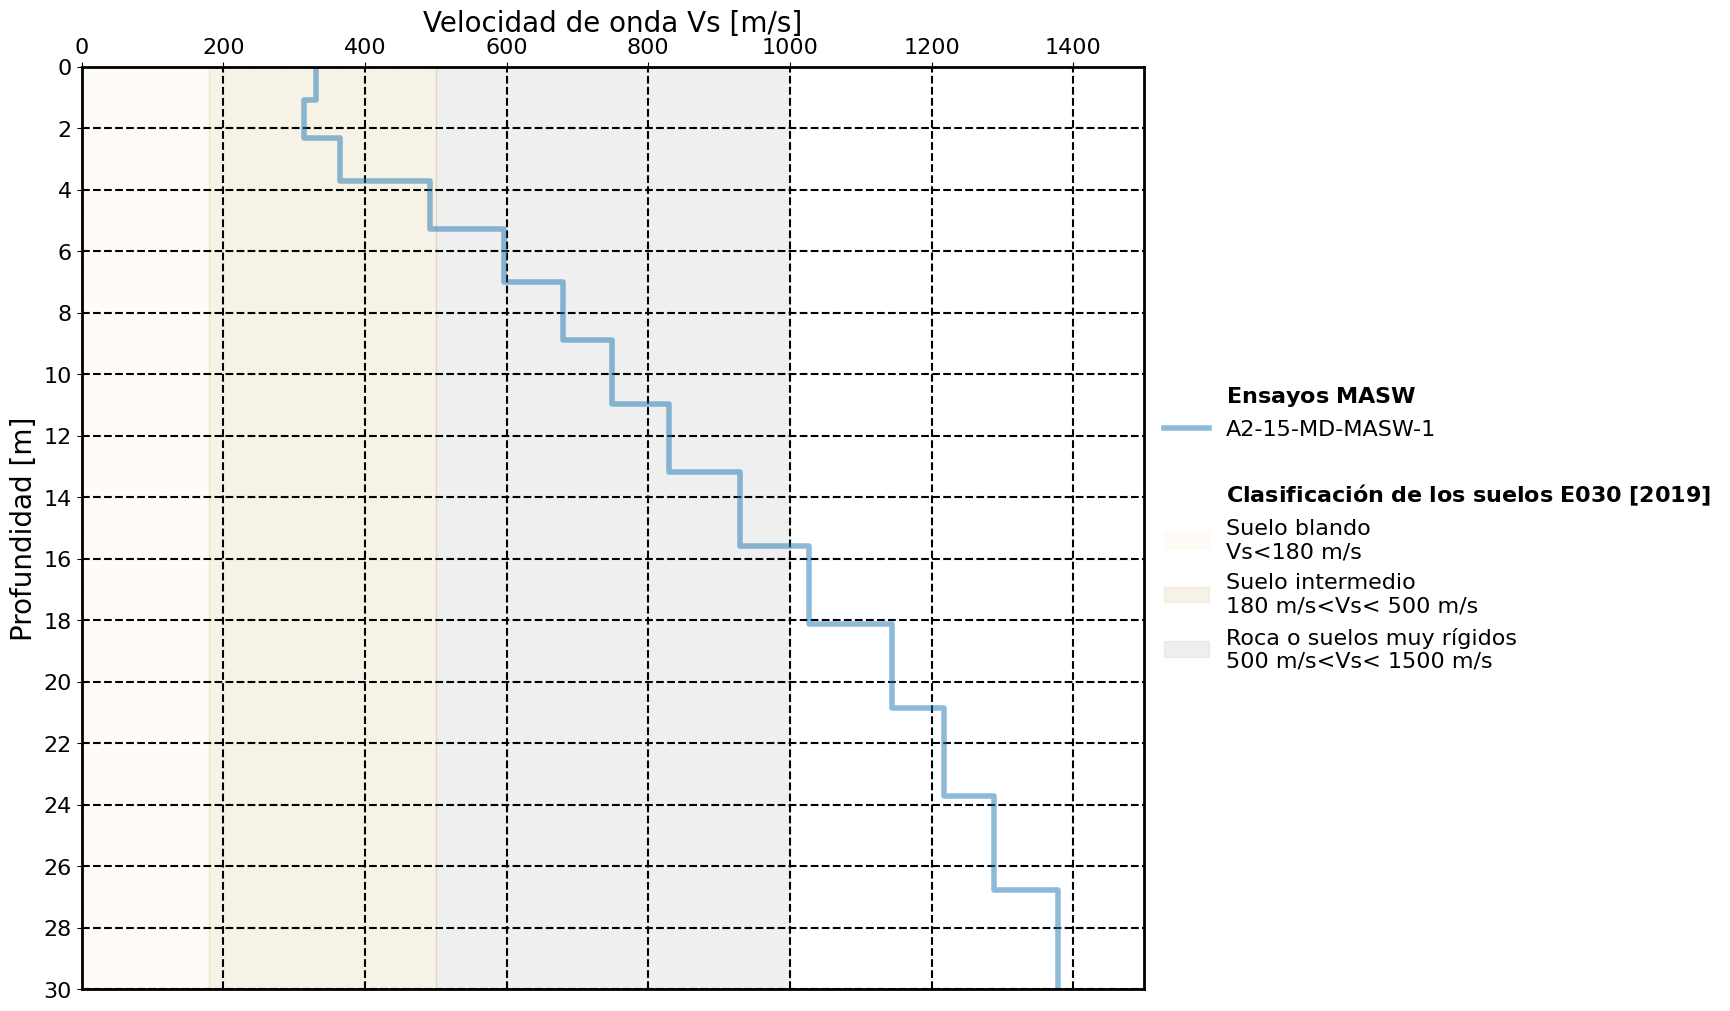

In [361]:
fig = plt.figure(figsize=(20, 10),constrained_layout=True)
gs = fig.add_gridspec(1,5, wspace=0.1)

#-----------------------------------------------------------
#Grafica de MASW
ax2 = fig.add_subplot(gs[0,0:4])
df_x2 = df_g[df_g['LOCA_NAME']==x_id].reset_index(drop=True)

# Lista para acumular todos los puntos
all_points = []

for j in range(len(df_x2)):
    m_id = df_x2['LOCA_ID'][j]
    df_x3 =  df_t[df_t['LOCA_ID']==m_id]
    df_x3 =  df_x3[df_x3['WGPG_PARA']=='VS'].reset_index(drop=True)
    all_points.append(df_x3)
        
    # Construcción del nuevo DataFrame
    new_rows = [(0.0, df_x3.loc[0, "WGPG_RDNG"])]  # Primer punto (0.0, primer valor de lectura)
    for k in range(len(df_x3)):
        new_rows.append((df_x3.loc[k, "WGPG_DPTH"], df_x3.loc[k, "WGPG_RDNG"]))
        if k < len(df_x3) - 1:
            new_rows.append((df_x3.loc[k, "WGPG_DPTH"], df_x3.loc[k + 1, "WGPG_RDNG"]))

    # Creación del nuevo DataFrame
    df_x3 = pd.DataFrame(new_rows, columns=["WGPG_DPTH", "WGPG_RDNG"])
    
    x = df_x3["WGPG_RDNG"]
    y = df_x3["WGPG_DPTH"]  
                    
    ax2.plot(x, y, linestyle='-', linewidth=4, alpha=0.5, label=m_id)


# Configurar títulos y etiquetas generales SOLO para ax2
ax2.set_ylabel("Profundidad [m]", fontsize=20)
ax2.set_xlabel("Velocidad de onda Vs [m/s]", fontsize=20)

# Mover ejes
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# Ejes mayores y menores en Y
ax2.yaxis.set_major_locator(MultipleLocator(2))  # Mayores cada 2 m

# Sombrear regiones E030
ax2.axvspan(0, 180, color='#FFDEAD', alpha=0.1, label="Suelo blando\nVs<180 m/s")
ax2.axvspan(180, 500, color='#B8860B', alpha=0.1, label="Suelo intermedio\n180 m/s<Vs< 500 m/s")
ax2.axvspan(500, 1000, color='#696969', alpha=0.1, label='Roca o suelos muy rígidos\n500 m/s<Vs< 1500 m/s')

# Crear elementos de leyenda para los grupos
grupo_ensayos = Line2D([0], [0], color='white', linestyle='', 
                        label=r"$\bf{Ensayos\ MASW}$")
grupo_clasificacion = Line2D([0], [0], color='white', linestyle='', 
                            label=r"$\bf{Clasificación\ de\ los\ suelos\ E030\ [2019]}$")
                                                                                         
espacio_vacio = Line2D([0], [0], color='white', linestyle='', label=" ")

# Obtener los elementos actuales
handles, labels = ax2.get_legend_handles_labels()

# Agregar los grupos a la leyenda
handles.insert(0, grupo_ensayos)  # Ensayos MASW
handles.insert(len(handles) - 3, espacio_vacio)  # Espacio antes de Clasificación
handles.insert(len(handles) - 3, grupo_clasificacion)  # Clasificación

# Mostrar leyenda con los grupos
ax2.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, frameon=False)

# Mostrar cuadrícula
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=1.5, color='black')
plt.grid(True, which="major", axis="x", linestyle="--", linewidth=1.5, color='black')

# Cambiar el formato de los ejes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Cambiar el borde de la gráfica
for spine in ax2.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# Establecer límites
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 1500)
ax2.invert_yaxis()
ax2.margins(0)

plt.show()